<a href="https://colab.research.google.com/github/lyc760214/teaching_and_reporting/blob/master/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 人工神經網路名詞解釋 - 以 Tensorflow 的 Keras 套件作為範例
### 作者：Y.C. Liu



## 引言
Keras套件是一個由Python語言編寫的介面，其目的是要讓一般使用者能更快建構一個所需的人工神經網路模型，其底層則是仰賴TensorFlow、Theano等機器學習框架運行。2017年Tensorflow團隊決定將Keras的加入其核心庫，因此現在若安裝較新版本的Tensorflow套件，則不須再額外進行Keras的套件。    
本文主要以手寫數字辨識的典型問題，來引導如何利用Tensorflow以內建的Keras套件來建構一個簡單的人工神經網路，並試著解釋常見名詞與概念。

## 三大主要模組
在人工神經網路模型的建立過程大致可以分為三個主要的步驟：
1. 網路架構設計 (structural model design)
2. 架構編譯 (Model compile)
3. 模型的訓練與測試 (Training and Testing)

而Keras針對提供了三大主要模組來協助使用者快速達成這些步驟：
1. Layers (層的模組)    
    提供典型網路層的模組，其中包含輸入層、全連接層、卷積層、遞歸層等常見的網路層    
    
2. Models (模型的模組)    
    編譯使用者自定義的網路架構，包含最佳化工具的選擇、損失函數的選擇、模型訓練時的參數設定等    
    
3. Preprocessing (預處理的模組)    
    資料預處理與其他可選工具的模組，包含可自定義的最佳化工具產生模組、網路架構視覺化的工具等    
    



## 匯入套件
為了能夠處理原始資料，建構模型以及訓練，我們必須匯入至少兩種套件
1. numpy (高效矩陣建立套件)
2. tensorflow (人工神經網路架構建立套件)

如果有額外需求，下列幾個套件亦是可考慮的匯入的
1. matplotlib (數據視覺化的繪圖套件)
2. pandas (提供更多表格型或索引型的變數類型)
3. scipy (提供一些額外的科學或數學常用的數據分析或處理工具)
4. scikit-learn (另一個非人工神經網路的機器學習套件，含有部分數據處理工具)

## 下載手寫辨識的練習資料
在此我們不免俗的使用tensorflow所提供來自於MNIST的手寫辨識資料。    
手寫資料以28\*28的灰階圖片共70,000組資料所組成，並被分割成60,000筆的訓練集與10,000筆的測試集。

In [0]:
import tensorflow as tf
import numpy as np

mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

print(np.shape(x_train), np.shape(y_train), np.shape(x_test), np.shape(y_test))

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


我們可以藉由matplotlib套件，將部分數據轉換回灰階的圖片，以供我們檢視。

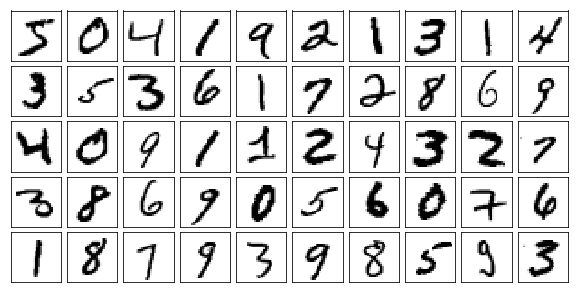

In [0]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 10, figsize=(10, 5.0), 
                        subplot_kw={'xticks':[],  'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))



for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i].reshape(28,28), cmap='binary')

為了進一步瞭解數據組的資料，我們可以使用pandas套件的計數工具來確認手寫辨識數據集中各類手寫數字存在的數量。對於訓練集中，我們會希望所有數字出現的次數的分部盡量維持一致，因為若是某特定數字過多，則建立出來的模型的預測結果會刻意偏向某數字。雖然這樣的問題可以藉由改變權重來調整，但理想還是是均分的狀況。

In [0]:
import pandas as pd

print(pd.value_counts(y_train, sort=False))

0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
dtype: int64


## 試做卷積神經網路

下圖是一個典型的卷積神經網路架構，我們將會試著建立相似的架構去進行我們的手寫數字辨識模型。

![](https://drive.google.com/uc?export=view&id=1h8r83HlQnlxh1oSrZ_nPTg91wwCgebMH)    

Architecture of a CNN ([source](https://www.mathworks.com/videos/introduction-to-deep-learning-what-are-convolutional-neural-networks--1489512765771.html))

### 建立輸入層 input layer
首先，我們先匯入Keras模組，然後建立網路的輸入層(input layer)。    
在輸入層的設定中，我們不需要告訴我們的網路模型我們總共有幾筆資料，只需要讓它知道我們每一筆資料是一個28\*28的圖片資料。

In [0]:
import tensorflow.keras as keras

main_input = keras.layers.Input(shape=(28,28))

###二維卷積層 2D convolution layer

接著，我們希望建立一個二維的卷積層來處理我們的原始圖片。


卷積的概念是建立一個或多個很小的「篩選器(filter)」，該篩選器代表著想要檢查原始圖片是否存在某種特定的數據分布狀況。    
例如我們有一個3\*3的篩選器，其數值分布如下：


[[0 0 1]
 [0 1 0]
 [1 0 0]]


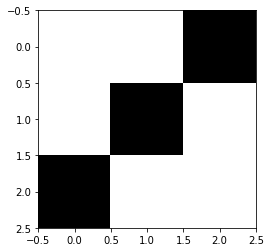

In [0]:
filter = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]])
print(filter)
plt.imshow(filter, cmap='binary')

在此我們演示一張手寫圖片在經過上面這個篩選器處理前與後的差異，其中該篩選器一次平移一個像素進行檢查：

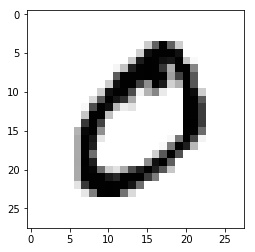

In [0]:
plt.imshow(x_train[1], cmap='binary')

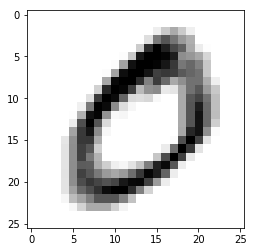

In [0]:
new_figure = np.zeros((26,26))
for i in range(0, 26):
  for j in range(0,26):
    new_figure[i, j] = np.sum(np.multiply(x_train[1,i:i+3,j:j+3], filter))

plt.imshow(new_figure, cmap='binary')

雖然我們自己定義的篩選器的作用不明顯，但是當手寫數字的局部區域呈現如同篩選器「右上往左下」的形狀時，卷積操作後的色彩將被加深(數值被強化)，而其他不相似的區域則變淺(數值被弱化)。

卷積操作其實就是利用篩選器，去檢查原始圖片中有哪些位置存在有與篩選器類似形狀的小區域，然後將其記錄在新的二維矩陣中。由於每一個篩選器可以各自產生一個新的二維矩陣，因此篩選器越多，則會產生越多的二維矩陣。

然而，實際在設置卷積層時，我們僅考慮篩選器的尺寸以及需要多少個篩選器。至於篩選器要長成什麼形狀，是藉由模型建立完成後的訓練，去自動建立出篩選器應該有的形狀。

值得一提的是，二維卷積的操作主要是針對圖片類型的數據，一般圖片通常除了尺寸外，還會有第三個維度代表著紅、綠、藍(R, G, B)，因此二維卷積層預設是要求送入的數據格式必須是三維。但我們的原始圖片為28\*28的尺寸，為了轉換成三維，因此必須將數據利用重塑層(reshape layer)轉換為28\*28\*1。



In [0]:
reshape_layer = keras.layers.Reshape(target_shape=(28,28,1))(main_input)

conv_layer = keras.layers.Conv2D(filters=32, kernel_size=(3,3))(reshape_layer)

W0703 03:50:02.114760 140607368705920 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### 活化層 activation layer
活化層是一種將現有的數據經過一個特殊的函式轉換，也是為什麼人工神經網路為什麼會被稱為類似「神經」的原因。

以常見的閾值操作為例，若我們希望將值小於0的數字一律視為0，我們可以在網路架構的適當位置添加一個活化層，使得每一個通過活化層的數字皆能大於0。

當然活化層不只有閾值型的函數操作，也有將數值轉換為介於0到1之間的正規化函數，或是其他類型的函數。

比較難以決定的事情是，活化層的函數選擇並不是十分的直觀，尤其在非輸入或輸出層兩端的活化層，有時必須要嘗試抽換不同類型的函數才能找到較佳的結果。

目前，較主流的閾值函數為ReLu，而較常見的正規化函數為softmax。這些函數已經直接內建在keras中，並若是有自定的需求，也可以參考手冊去做額外的調整。

In [0]:
act_layer = keras.layers.Activation(activation="relu")(conv_layer)

### 池化層 pooling layer

池化層是一種經常於卷積層之後的數具操作。一般而言，在卷積層後所產生的二維數據代表著每個區域是否存在有類似篩選器的形狀分布。然而，對於一些比較複雜且尺寸較大的圖片，某些篩選出來後的結果可能會有過度採樣的現象。利用池化操作可以將卷積所產生的結果在不遺失過多資訊下保留其圖形分布。

或者說，池化是一種對圖形做低失真縮小的技巧，目的是在壓縮圖片的同時保留重要的特徵。只是，池化層要注意的設定有兩個，一個池化的尺寸，一個是池化操作時的滑動(slide)距離，這兩個設定會影響壓縮的比例。

常見的池化方式有最大值池化或是平均值池化。在此我們試著將一張原始的手寫圖片進行尺寸為2\*2，滑動距離為2的最大值池化操作前後的比較：

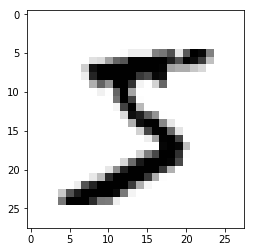

In [0]:
plt.imshow(x_train[0], cmap='binary')

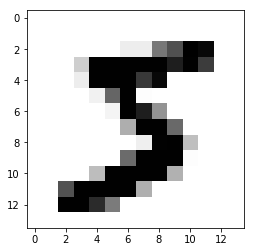

In [0]:
new_figure = np.zeros((14,14))
for i in range(0,27,2):
  for j in range(0,27,2):
    new_figure[int(i/2), int(j/2)] = np.amax(x_train[0,i:i+2,j:j+2])

plt.imshow(new_figure, cmap='binary')

In [0]:
pool_layer = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(act_layer)

### 添加第二次卷積、活化與池化操作

卷積層的操作是在建立多個篩選器去確認圖片中是否存在有某些特徵。活化層則是將某些不明顯的特徵直接去除，僅保留較為明顯的部分。池化層則是將處理後的結果再一步進行壓縮，讓人工神經網路內的神經元(特徵)不至於過度增加。

In [0]:
conv_layer_2 = keras.layers.Conv2D(filters=32, kernel_size=(3,3))(pool_layer)
act_layer_2 = keras.layers.Activation(activation="relu")(conv_layer_2)
pool_layer_2 = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(act_layer_2)

### 展開層 flatten layer
由於我們最後的目標是建立手寫數字辨識的預測模型，也就是預測出一維的結果。但前面所輸入以及處理的過程中都是以二維圖形的概念去建立，因此必須將二維的圖片特徵展開為一維的排列方式。

在這個步驟原則上不會改變數值，結果類似於先前的重塑(reshape)維度的操作。不過使用展開(flatten)而不使用重塑(reshape)的好處是我們不需要深知先前的網路層操作如何改變特徵矩陣的尺寸，只要直接使用展開層鋪平即可。

In [0]:
flat_layer = keras.layers.Flatten()(pool_layer_2)

### 丟棄層 dropout layer
在我們進行模型訓練時，每一次的訓練將會微調所有神經元的權重，目的是希望能夠找出一個將特徵(feature)轉換成標籤(label)的最佳權重組合。但是，若我們的網路架構是複雜且龐大的，由於過多可調整的權重，很容易在訓練的最後產生出對於訓練集過度擬合(overfitting)的結果。換言之，我們將獲得的是一個沒有普遍性的預測模型。    
為了解決這個問題，丟棄層的存在可以讓模型存在有隨機性，使得神經元之間相關性下降，不會使每個神經元的權重過於與訓練集相關。    
只不過，丟棄層在較小的網路架構下反而會造成準確性的下降，具體而言是否該加入丟棄層還須進行測試。此外，當面對的網路模型是遞歸神經網路時，由於遞歸神經網路有梯度消失的問題，丟棄層的存在可能會使得該問題變得更加嚴重。

In [0]:
dropout_layer = keras.layers.Dropout(rate=0.5)(flat_layer)

### 全連接層 dense layer
全連接層顧名思義就是該層的每一個神經元，是來自於前一層的所有神經元的總和，只不過前一層的神經元對於該層的任意神經元都有不相同的權重。全連接層是人工神經網路最具代表性的基礎網路架構，在配合活化層(或是直接設置活化函數)下，可以使得所有的輸入特徵群以非線性方式組合成新的特徵群。另外全連接層也經常作為最後的輸出層使用。

在此，我們將前面已建立的網路連結至全連接層，並將該層的神經元設為10以代表我們希望預測手寫的圖像可能為哪一種數字。其中，我們直接設立全連接層的活化函數為softmax，也就是希望導出一個數值範圍在0~1之間的結果。換言之，我們藉由這樣的架構可以使一張手寫的圖像送入模型後，輸出是每一種數字可能的機率。接著我們再利用挑選最高機率的答案作為我們最後預測的結果。

In [0]:
main_output = keras.layers.Dense(units=10,activation='softmax')(dropout_layer)

### 網路架構的編譯
在前述的過程中，我們建立了一個完整的網路架構。接著，我們要將輸入的資料、用來對照的答案、最佳化器以及損失函數一併與網路進行編譯。

在tensorflow中，我們可以利用Model這個類別，建立出一個能夠連接訓練集的特徵與標籤的物件，並且藉由compile方法將合適的最佳化器(optimizer)、損失函數(loss)以及希望在訓練過程中閱覽的一些衡量指標(metrics)編譯在一起，使得接下來的訓練過程中能夠依照我們的需求找出最佳的權重。

此外，為了能夠檢視我們剛剛所建立的網路，我們可以利用summary方法對我們的網路進行摘要，瞭解每一層的神經元數目、需要訓練的參數有多少等等。另外，也有額外的plot_model工具可以視覺化網路的每一個層之間的連接關係。


In [0]:
cnn_model = keras.models.Model(inputs=[main_input], outputs=[main_output])
cnn_model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['accuracy'])
cnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 32)        0     

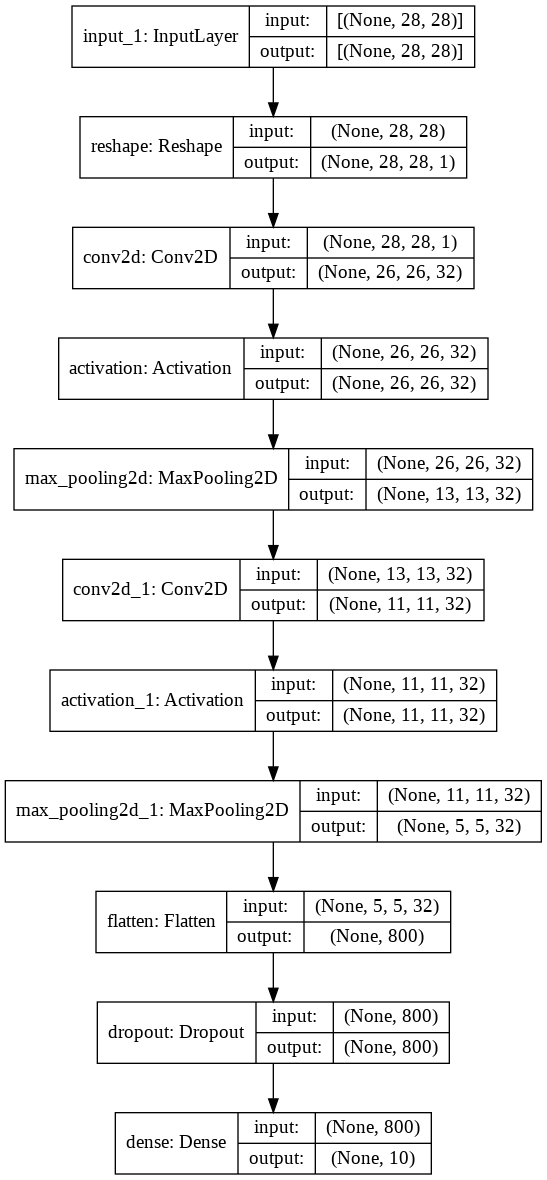

In [0]:
keras.utils.plot_model(cnn_model, show_shapes=True, show_layer_names=True)

### 進行訓練

在完成網路架構、設定好最佳化與損失函數後，我們便要將手寫數字的所有圖片以及相對應的答案送入我們的模型中進行訓練。

由於人工神經網路的學習方式是利用每一次送入特徵後去預測其標籤，接著在與正確答案比對瞭解誤差多少，再利用反向傳播法將這些誤差逐步回推給每一層神經元進行權重微調，因此整份訓練集需要重複的送入。此外，若是一張圖片送入便要微調一次權重，則會過於曠日廢時。所以，目前的學習方式是以數筆資料送入後再微調一次權重，而整份訓練集要重覆送入數次至數十次，或是根據訓練的情況決定終止條件。

在tensorflow中，epoch代表整份訓練集要重覆送入幾次，而batch_size則代表每多少筆圖片送入後便微調一次各神經元權重。

訓練過程的程式碼如下：

In [0]:
cnn_model.fit(x_train, y_train, batch_size=64, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 41s 678us/sample - loss: 1.2880 - acc: 0.7949
Epoch 2/5
60000/60000 [==============================] - 40s 664us/sample - loss: 0.2480 - acc: 0.9252
Epoch 3/5
60000/60000 [==============================] - 40s 665us/sample - loss: 0.1966 - acc: 0.9401
Epoch 4/5
60000/60000 [==============================] - 40s 671us/sample - loss: 0.1638 - acc: 0.9504
Epoch 5/5
60000/60000 [==============================] - 40s 662us/sample - loss: 0.1415 - acc: 0.9572


在訓練完成後，我們分別評估預測模型對訓練集自身以及測試集的準確度：

In [0]:
cnn_model.evaluate(x_train, y_train)

60000/60000 [==============================] - 14s 241us/sample - loss: 0.0473 - acc: 0.9852


[0.04727262574355894, 0.9852167]

In [0]:
cnn_model.evaluate(x_test, y_test)

10000/10000 [==============================] - 2s 242us/sample - loss: 0.0572 - acc: 0.9818


[0.057214109995414035, 0.9818]

我們可以觀察到，我們的預測模型對訓練集本身的準確度達0.9852，並且對訓練集而言為0.9818。

最後我們從測試集中隨機抽10組圖片並瀏覽預測狀況：

In [0]:
np.random.seed(seed=17)
idx = np.random.randint(len(x_test), size=10)
prediction = np.argmax(cnn_model.predict(x_test[idx]), axis=1)
print(prediction)
print(y_test[idx])

[2 5 6 3 2 6 5 1 3 8]
[2 5 6 3 2 6 5 1 3 8]
